# Modelo de Regresión para Series de Tiempo con Imágenes


#### Este trabajo surge como el estudio previo a la creación del modelo final de mi **TFG**.

#### Mi **TFG** consiste en desarrollar un modelo **Imitation Learning** o **Behavior Cloninig** apoyado con **Dagger** dentro de un videojuego

####  **Imitation Learning** o **Behavior Cloninig** consiste en un conjunto de técnicas relacionadas con Reinforcement Learning, donde mediante muestras de un experto un humano, la inteligencia artificial aprende a realizar una acción.

#### En el caso de mi TFG, se trataba de enseñar a una inteligencia artificial a jugar de forma autónoma a un videojuego.

#### Para esto, al entrenar el modelo, necesité utilizar series de tiempo, ya que mi dataset estaba compuesto por:


*   5 imágenes en formato de frames del mapa.
*   5 imágenes en formato de frames de lo que veía el jugador.
*   Una lista que representa el movimiento del personaje con el ratón.

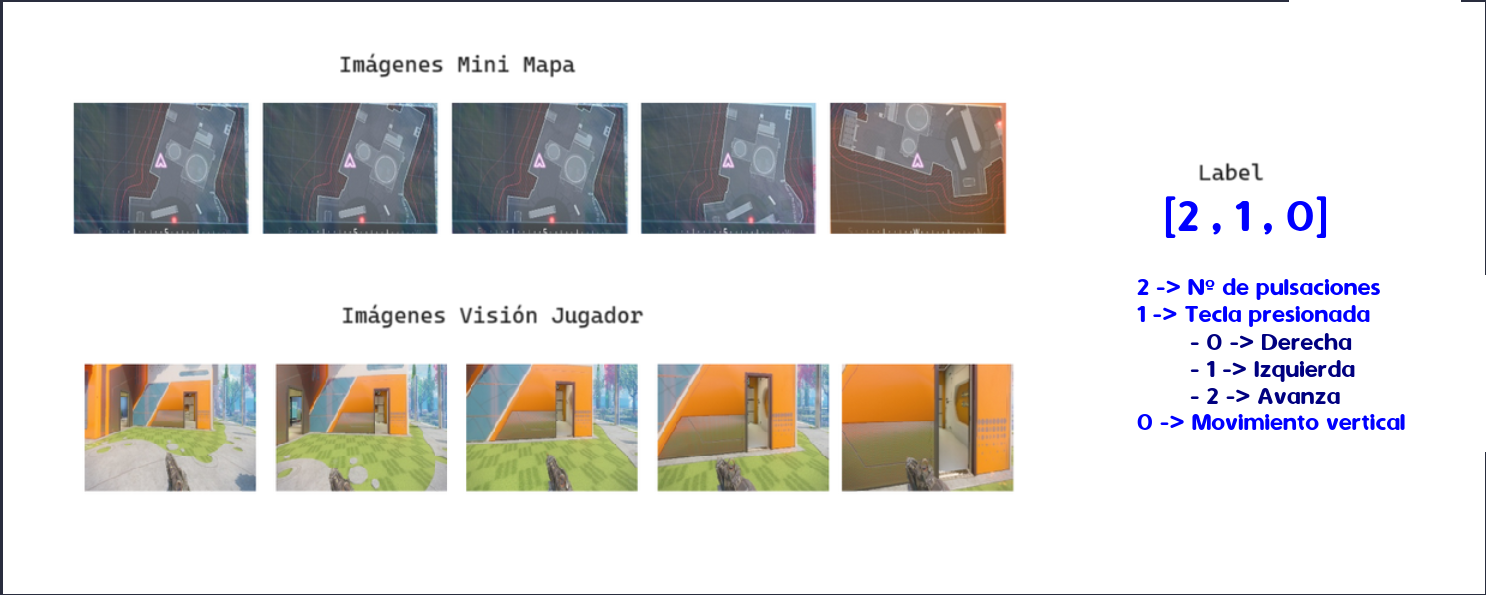

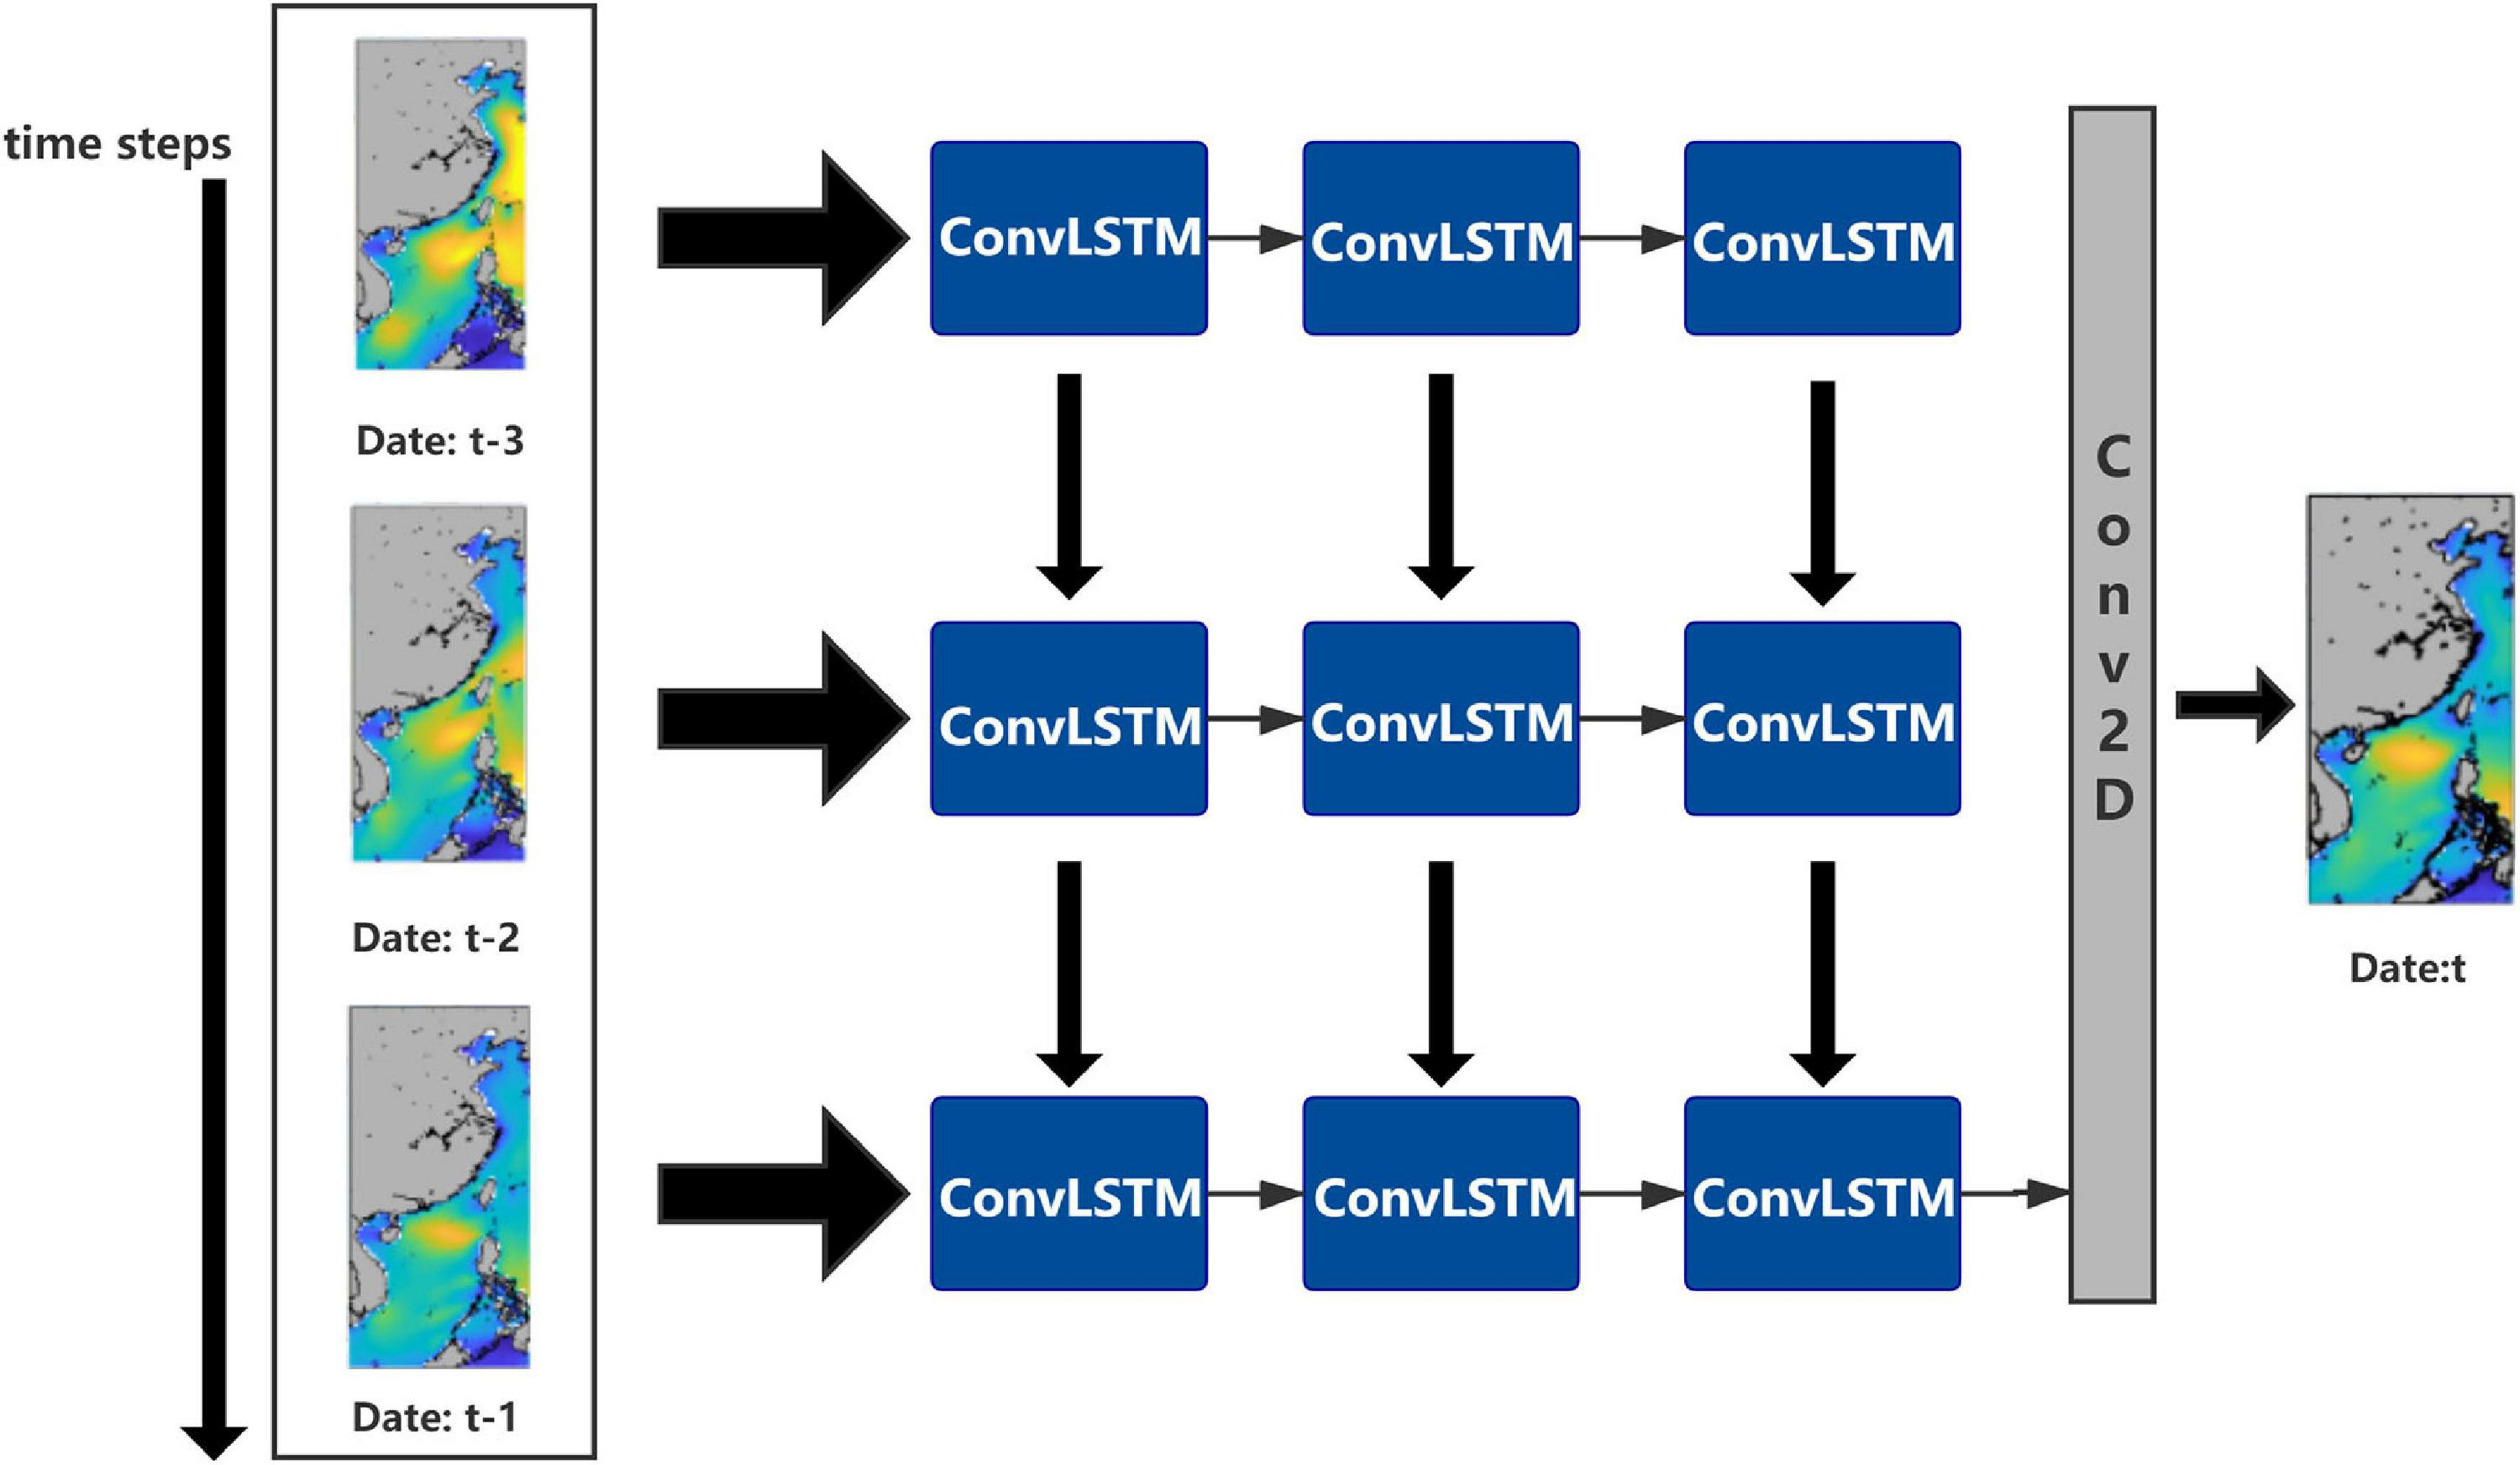

# Resumen del Notebook
#### Para ello, después de recolectar suficientes muestras para crear el modelo, comencé su desarrollo.

#### En este notebook se lleva a cabo:


*   Estudio del Conjunto de Datos
*   Preprocesamiento tanto de las imágenes como de la variable a predecir
*   Preprocesamiento con herramientas como MinMaxScaler o estructuras de normalización
*   Creación de una estructura de batches personalizada para este problema
*   Creacion de modelo de Serie de Tiempo
*   Optimización del modelo
*   Estudio de los resultados Obtenidos

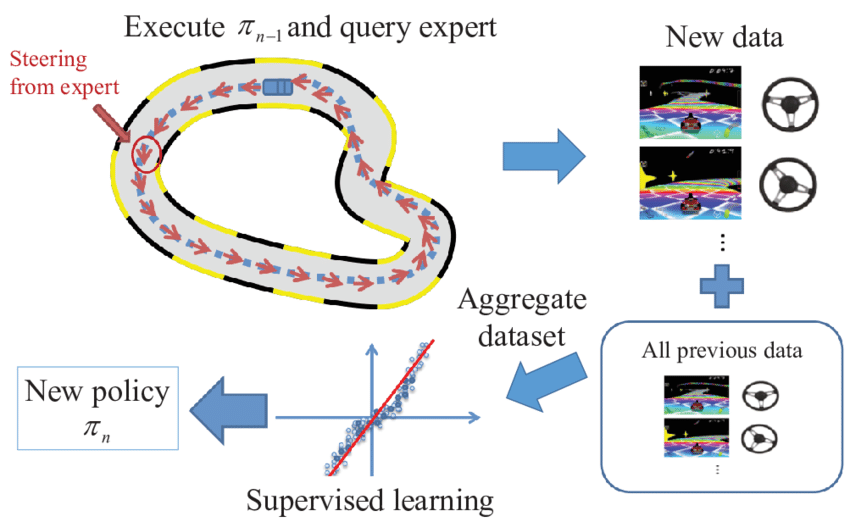

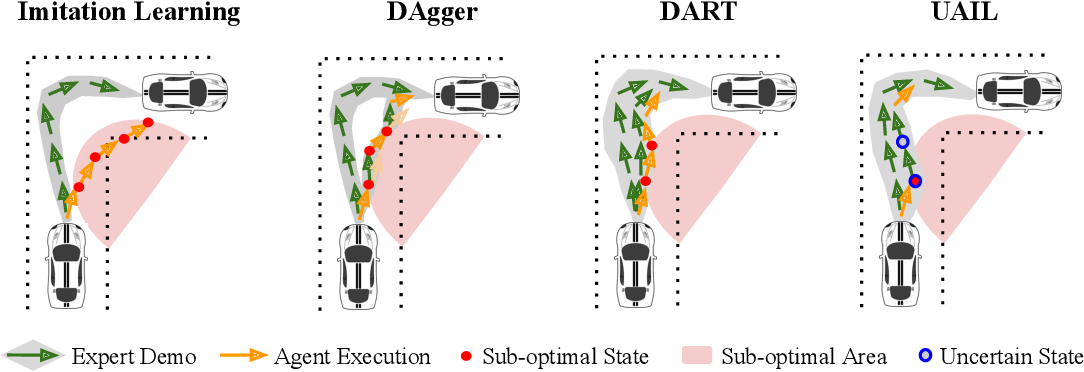

In [2]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

if os.path.exists('drive/MyDrive/cod.zip'):
    print("La ruta existe")
else:
    print("La ruta no existe")

Mounted at /content/drive
La ruta existe


In [3]:
with zipfile.ZipFile('drive/MyDrive/cod.zip', 'r') as zip_ref:
    zip_ref.extractall('cod')

print("El directorio actual es:", os.getcwd())

El directorio actual es: /content


In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
import tensorflow as tf

2024-08-16 19:47:23.262290: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 19:47:23.291868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Configurar TensorFlow para permitir el crecimiento de la memoria de la GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-07-10 12:51:07.154439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 12:51:07.907338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 12:51:07.907586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

GPU encontrada: /device:GPU:0


2024-07-11 15:12:54.351889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:12:54.381138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 15:12:54.381339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
os.chdir("cod/modelos")

In [2]:
os.getcwd()

'/media/recesvinto/3640d90a-b4df-40aa-a056-59c4e0eef6fd/TFG/TFG_Imitation_learning/modelos'

In [ ]:
df_mini = pd.read_csv('../datos/grabacion/datos_bo3_minimapa_03.csv')
df_pov = pd.read_csv('../datos/grabacion/datos_bo3_pov_03.csv')

In [3]:
df_mini = pd.read_csv('../datos/grabacion/datos_subway_mini.csv')
df_pov = pd.read_csv('../datos/grabacion/datos_subway_pov.csv')

##  Data Augmentation

In [4]:
import os
import shutil

def aplicar_Data_Augmentation(df):
    df_nuevo = pd.DataFrame()
    folder_augmentation = '../datos/grabacion/pov_augmentation'
    filas = []

    # Comprobar si la carpeta existe
    if os.path.exists(folder_augmentation):
        print("Eliminado..")
        # Si existe, eliminarla
        shutil.rmtree(folder_augmentation)
    
    print("Creando..")
    os.makedirs(folder_augmentation)

    for index, row in df.iterrows():
        df_row_CN = {}
        df_row_BR = {}
        intensidad = np.random.randint(1.5,3)
        indice_img = 0
        for col in df.columns:
            indice_img = indice_img + 1
            if col !=  "mouse_final":
                # Obtener la ruta de la imagen
                imagen = Image.open("../" + row[col])
                # Aplicamos transformacion
                enhancer = ImageEnhance.Contrast(imagen)
                imagen_augment01 = enhancer.enhance(intensidad)  # Aumento de contraste
                
                enhancer = ImageEnhance.Brightness(imagen)
                imagen_augment02 = enhancer.enhance(intensidad)  # Aumento de brillo

                # Ruta
                ruta_img = "datos/grabacion/pov_augmentation" + "/imagen_"+str(index)+str(indice_img)
                # Guardar la imagen transformada
                imagen_augment01.save("../"+str(ruta_img)+"CN.jpg")
                imagen_augment02.save("../"+str(ruta_img)+"BR.jpg")
                # Guardamos img en csv
                df_row_CN[col] = str(ruta_img) + "CN.jpg"
                df_row_BR[col] = str(ruta_img) + "BR.jpg"
            else:
                df_row_CN[col] = row[col]
                df_row_BR[col] = row[col]
        
        filas.append(pd.DataFrame([df_row_CN]))
        filas.append(pd.DataFrame([df_row_BR]))

    df_nuevo = pd.concat(filas, ignore_index=True)
    return df_nuevo

## Preproceso del Conjunto de los Datos

In [5]:
df_pov

pov_01  \
0        datos/grabacion/pov/pov_12-16-50-30-752791.jpg   
1        datos/grabacion/pov/pov_12-16-50-30-752791.jpg   
2        datos/grabacion/pov/pov_12-16-50-31-783654.jpg   
3        datos/grabacion/pov/pov_12-16-50-30-752791.jpg   
4        datos/grabacion/pov/pov_12-16-50-31-783654.jpg   
...                                                 ...   
2226667  datos/grabacion/pov/pov_16-19-40-02-805487.jpg   
2226668  datos/grabacion/pov/pov_16-19-40-03-847970.jpg   
2226669  datos/grabacion/pov/pov_16-19-40-04-890527.jpg   
2226670  datos/grabacion/pov/pov_16-19-40-05-932197.jpg   
2226671  datos/grabacion/pov/pov_16-19-40-06-968558.jpg   

                                                 pov_02  \
0        datos/grabacion/pov/pov_12-16-50-30-870098.jpg   
1        datos/grabacion/pov/pov_12-16-50-30-870098.jpg   
2        datos/grabacion/pov/pov_12-16-50-31-901090.jpg   
3        datos/grabacion/pov/pov_12-16-50-30-870098.jpg   
4        datos/grabacion/pov/pov_12-16-50-31-901090.jpg   
...                                                 ...   
2226667  datos/grabacion/pov/pov_16-19-40-02-922460.jpg   
2226668  datos/grabacion/pov/pov_16-19-40-03-967737.jpg   
2226669  datos/grabacion/pov/pov_16-19-40-05-007680.jpg   
2226670  datos/grabacion/pov/pov_16-19-40-06-049775.jpg   
2226671  datos/grabacion/pov/pov_16-19-40-07-084536.jpg   

                                                 pov_03  \
0        datos/grabacion/pov/pov_12-16-50-30-987286.jpg   
1        datos/grabacion/pov/pov_12-16-50-30-987286.jpg   
2        datos/grabacion/pov/pov_12-16-50-32-017218.jpg   
3        datos/grabacion/pov/pov_12-16-50-30-987286.jpg   
4        datos/grabacion/pov/pov_12-16-50-32-017218.jpg   
...                                                 ...   
2226667  datos/grabacion/pov/pov_16-19-40-03-039342.jpg   
2226668  datos/grabacion/pov/pov_16-19-40-04-084941.jpg   
2226669  datos/grabacion/pov/pov_16-19-40-05-125169.jpg   
2226670  datos/grabacion/pov/pov_16-19-40-06-166778.jpg   
2226671  datos/grabacion/pov/pov_16-19-40-07-201516.jpg   

                                                 pov_04  \
0        datos/grabacion/pov/pov_12-16-50-31-102957.jpg   
1        datos/grabacion/pov/pov_12-16-50-31-102957.jpg   
2        datos/grabacion/pov/pov_12-16-50-32-134183.jpg   
3        datos/grabacion/pov/pov_12-16-50-31-102957.jpg   
4        datos/grabacion/pov/pov_12-16-50-32-134183.jpg   
...                                                 ...   
2226667  datos/grabacion/pov/pov_16-19-40-03-156272.jpg   
2226668  datos/grabacion/pov/pov_16-19-40-04-202544.jpg   
2226669  datos/grabacion/pov/pov_16-19-40-05-242072.jpg   
2226670  datos/grabacion/pov/pov_16-19-40-06-283583.jpg   
2226671  datos/grabacion/pov/pov_16-19-40-07-319365.jpg   

                                                 pov_05 mouse_final  
0        datos/grabacion/pov/pov_12-16-50-31-216725.jpg   [1, 2, 0]  
1        datos/grabacion/pov/pov_12-16-50-31-216725.jpg   [1, 2, 0]  
2        datos/grabacion/pov/pov_12-16-50-32-253445.jpg   [1, 1, 0]  
3        datos/grabacion/pov/pov_12-16-50-31-216725.jpg   [1, 2, 0]  
4        datos/grabacion/pov/pov_12-16-50-32-253445.jpg   [1, 1, 0]  
...                                                 ...         ...  
2226667  datos/grabacion/pov/pov_16-19-40-03-273202.jpg   [1, 3, 0]  
2226668  datos/grabacion/pov/pov_16-19-40-04-319981.jpg   [1, 2, 0]  
2226669  datos/grabacion/pov/pov_16-19-40-05-359794.jpg   [1, 2, 0]  
2226670  datos/grabacion/pov/pov_16-19-40-06-400142.jpg   [1, 2, 0]  
2226671  datos/grabacion/pov/pov_16-19-40-07-435172.jpg   [1, 2, 0]  

[2226672 rows x 6 columns]

In [6]:
import ast

#Eliminamos duplicados
df_mini.drop_duplicates(inplace=True)
df_pov.drop_duplicates(inplace=True)

# Restablecer el índice
df_mini.reset_index(drop=True, inplace=True)
df_pov.reset_index(drop=True, inplace=True)

# Convertir la columna de tipo object a listas de enteros
df_mini['mouse_final'] = df_mini['mouse_final'].apply(ast.literal_eval)
df_pov['mouse_final'] = df_pov['mouse_final'].apply(ast.literal_eval)

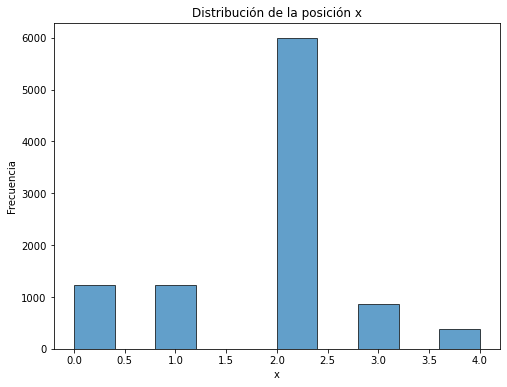

In [7]:
# Extraer la primera posición sin modificar el DataFrame
x_positions = df_mini['mouse_final'].apply(lambda x: x[1])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(x_positions, bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

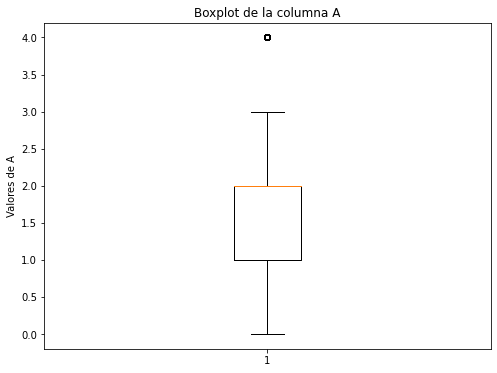

In [8]:
# Crear un boxplot para la columna 'A'
plt.figure(figsize=(8, 6))
plt.boxplot(x_positions)
plt.title('Boxplot de la columna A')
plt.ylabel('Valores de A')
plt.show()

In [9]:
# Extraer la primera posición sin modificar el DataFrame
x_positions_2 = df_mini['mouse_final'].apply(lambda x: str(x[0])+str(x[1]))
x_positions_3 = df_pov['mouse_final'].apply(lambda x: str(x[0])+str(x[1]))

# Sustituir la columna original
df_mini['mouse_final'] = x_positions_2
df_pov['mouse_final'] = x_positions_3

In [10]:
print(df_mini.shape)
print(df_pov.shape)

(9687, 6)
(9687, 6)


In [11]:
# Eliminamos datos sucios
df_pov = df_pov[(df_pov['mouse_final'] != "20") & (df_pov['mouse_final'] != "21") & (df_pov['mouse_final'] != "22")& (df_pov['mouse_final'] != "23")& (df_pov['mouse_final'] != "24")& (df_pov['mouse_final'] != "02")& (df_pov['mouse_final'] != "30")]
df_pov.reset_index(drop=True, inplace=True)

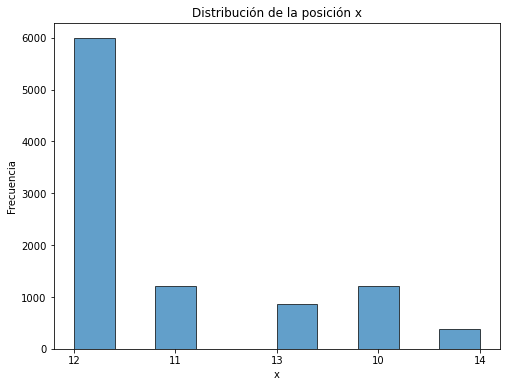

In [12]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(df_pov['mouse_final'], bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

## Aplicamos Data Augmentation

In [13]:
new_df = aplicar_Data_Augmentation(df_pov[df_pov['mouse_final'] != "12"])

Creando..


In [14]:
new_df

pov_01  \
0      datos/grabacion/pov_augmentation/imagen_11CN.jpg   
1      datos/grabacion/pov_augmentation/imagen_11BR.jpg   
2      datos/grabacion/pov_augmentation/imagen_21CN.jpg   
3      datos/grabacion/pov_augmentation/imagen_21BR.jpg   
4      datos/grabacion/pov_augmentation/imagen_31CN.jpg   
...                                                 ...   
7325  datos/grabacion/pov_augmentation/imagen_96381B...   
7326  datos/grabacion/pov_augmentation/imagen_96421C...   
7327  datos/grabacion/pov_augmentation/imagen_96421B...   
7328  datos/grabacion/pov_augmentation/imagen_96451C...   
7329  datos/grabacion/pov_augmentation/imagen_96451B...   

                                                 pov_02  \
0      datos/grabacion/pov_augmentation/imagen_12CN.jpg   
1      datos/grabacion/pov_augmentation/imagen_12BR.jpg   
2      datos/grabacion/pov_augmentation/imagen_22CN.jpg   
3      datos/grabacion/pov_augmentation/imagen_22BR.jpg   
4      datos/grabacion/pov_augmentation/imagen_32CN.jpg   
...                                                 ...   
7325  datos/grabacion/pov_augmentation/imagen_96382B...   
7326  datos/grabacion/pov_augmentation/imagen_96422C...   
7327  datos/grabacion/pov_augmentation/imagen_96422B...   
7328  datos/grabacion/pov_augmentation/imagen_96452C...   
7329  datos/grabacion/pov_augmentation/imagen_96452B...   

                                                 pov_03  \
0      datos/grabacion/pov_augmentation/imagen_13CN.jpg   
1      datos/grabacion/pov_augmentation/imagen_13BR.jpg   
2      datos/grabacion/pov_augmentation/imagen_23CN.jpg   
3      datos/grabacion/pov_augmentation/imagen_23BR.jpg   
4      datos/grabacion/pov_augmentation/imagen_33CN.jpg   
...                                                 ...   
7325  datos/grabacion/pov_augmentation/imagen_96383B...   
7326  datos/grabacion/pov_augmentation/imagen_96423C...   
7327  datos/grabacion/pov_augmentation/imagen_96423B...   
7328  datos/grabacion/pov_augmentation/imagen_96453C...   
7329  datos/grabacion/pov_augmentation/imagen_96453B...   

                                                 pov_04  \
0      datos/grabacion/pov_augmentation/imagen_14CN.jpg   
1      datos/grabacion/pov_augmentation/imagen_14BR.jpg   
2      datos/grabacion/pov_augmentation/imagen_24CN.jpg   
3      datos/grabacion/pov_augmentation/imagen_24BR.jpg   
4      datos/grabacion/pov_augmentation/imagen_34CN.jpg   
...                                                 ...   
7325  datos/grabacion/pov_augmentation/imagen_96384B...   
7326  datos/grabacion/pov_augmentation/imagen_96424C...   
7327  datos/grabacion/pov_augmentation/imagen_96424B...   
7328  datos/grabacion/pov_augmentation/imagen_96454C...   
7329  datos/grabacion/pov_augmentation/imagen_96454B...   

                                                 pov_05 mouse_final  
0      datos/grabacion/pov_augmentation/imagen_15CN.jpg          11  
1      datos/grabacion/pov_augmentation/imagen_15BR.jpg          11  
2      datos/grabacion/pov_augmentation/imagen_25CN.jpg          13  
3      datos/grabacion/pov_augmentation/imagen_25BR.jpg          13  
4      datos/grabacion/pov_augmentation/imagen_35CN.jpg          13  
...                                                 ...         ...  
7325  datos/grabacion/pov_augmentation/imagen_96385B...          11  
7326  datos/grabacion/pov_augmentation/imagen_96425C...          11  
7327  datos/grabacion/pov_augmentation/imagen_96425B...          11  
7328  datos/grabacion/pov_augmentation/imagen_96455C...          13  
7329  datos/grabacion/pov_augmentation/imagen_96455B...          13  

[7330 rows x 6 columns]

In [15]:
df_pov = pd.concat([df_pov, new_df], ignore_index=True)

In [16]:
df_pov

pov_01  \
0         datos/grabacion/pov/pov_12-16-50-30-752791.jpg   
1         datos/grabacion/pov/pov_12-16-50-31-783654.jpg   
2         datos/grabacion/pov/pov_12-16-50-32-824935.jpg   
3         datos/grabacion/pov/pov_12-16-50-33-942819.jpg   
4         datos/grabacion/pov/pov_12-16-50-34-981293.jpg   
...                                                  ...   
16980  datos/grabacion/pov_augmentation/imagen_96381B...   
16981  datos/grabacion/pov_augmentation/imagen_96421C...   
16982  datos/grabacion/pov_augmentation/imagen_96421B...   
16983  datos/grabacion/pov_augmentation/imagen_96451C...   
16984  datos/grabacion/pov_augmentation/imagen_96451B...   

                                                  pov_02  \
0         datos/grabacion/pov/pov_12-16-50-30-870098.jpg   
1         datos/grabacion/pov/pov_12-16-50-31-901090.jpg   
2         datos/grabacion/pov/pov_12-16-50-32-942703.jpg   
3         datos/grabacion/pov/pov_12-16-50-34-060454.jpg   
4         datos/grabacion/pov/pov_12-16-50-35-099414.jpg   
...                                                  ...   
16980  datos/grabacion/pov_augmentation/imagen_96382B...   
16981  datos/grabacion/pov_augmentation/imagen_96422C...   
16982  datos/grabacion/pov_augmentation/imagen_96422B...   
16983  datos/grabacion/pov_augmentation/imagen_96452C...   
16984  datos/grabacion/pov_augmentation/imagen_96452B...   

                                                  pov_03  \
0         datos/grabacion/pov/pov_12-16-50-30-987286.jpg   
1         datos/grabacion/pov/pov_12-16-50-32-017218.jpg   
2         datos/grabacion/pov/pov_12-16-50-33-062221.jpg   
3         datos/grabacion/pov/pov_12-16-50-34-177557.jpg   
4         datos/grabacion/pov/pov_12-16-50-35-217056.jpg   
...                                                  ...   
16980  datos/grabacion/pov_augmentation/imagen_96383B...   
16981  datos/grabacion/pov_augmentation/imagen_96423C...   
16982  datos/grabacion/pov_augmentation/imagen_96423B...   
16983  datos/grabacion/pov_augmentation/imagen_96453C...   
16984  datos/grabacion/pov_augmentation/imagen_96453B...   

                                                  pov_04  \
0         datos/grabacion/pov/pov_12-16-50-31-102957.jpg   
1         datos/grabacion/pov/pov_12-16-50-32-134183.jpg   
2         datos/grabacion/pov/pov_12-16-50-33-179664.jpg   
3         datos/grabacion/pov/pov_12-16-50-34-294548.jpg   
4         datos/grabacion/pov/pov_12-16-50-35-334015.jpg   
...                                                  ...   
16980  datos/grabacion/pov_augmentation/imagen_96384B...   
16981  datos/grabacion/pov_augmentation/imagen_96424C...   
16982  datos/grabacion/pov_augmentation/imagen_96424B...   
16983  datos/grabacion/pov_augmentation/imagen_96454C...   
16984  datos/grabacion/pov_augmentation/imagen_96454B...   

                                                  pov_05 mouse_final  
0         datos/grabacion/pov/pov_12-16-50-31-216725.jpg          12  
1         datos/grabacion/pov/pov_12-16-50-32-253445.jpg          11  
2         datos/grabacion/pov/pov_12-16-50-33-297422.jpg          13  
3         datos/grabacion/pov/pov_12-16-50-34-411356.jpg          13  
4         datos/grabacion/pov/pov_12-16-50-35-450736.jpg          12  
...                                                  ...         ...  
16980  datos/grabacion/pov_augmentation/imagen_96385B...          11  
16981  datos/grabacion/pov_augmentation/imagen_96425C...          11  
16982  datos/grabacion/pov_augmentation/imagen_96425B...          11  
16983  datos/grabacion/pov_augmentation/imagen_96455C...          13  
16984  datos/grabacion/pov_augmentation/imagen_96455B...          13  

[16985 rows x 6 columns]

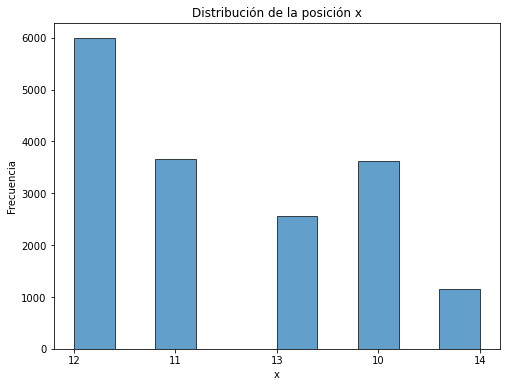

In [17]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(df_pov['mouse_final'], bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

## One-Hot Encoding

In [18]:
# Crear un DataFrame con las columnas de one-hot encoding
one_hot_df = pd.get_dummies(df_pov['mouse_final'], prefix='label')

# Unir el DataFrame original con el DataFrame de one-hot encoding
df_pov = pd.concat([df_pov, one_hot_df], axis=1)

df_pov = df_pov.drop('mouse_final', axis=1)

## Lista con las etiquetas 

In [19]:
ETIQUETAS = np.array(df_pov.filter(like='label').columns.tolist())

In [20]:
ETIQUETAS

array(['label_10', 'label_11', 'label_12', 'label_13', 'label_14'],
      dtype='<U8')

## Visualizacion DataFrame

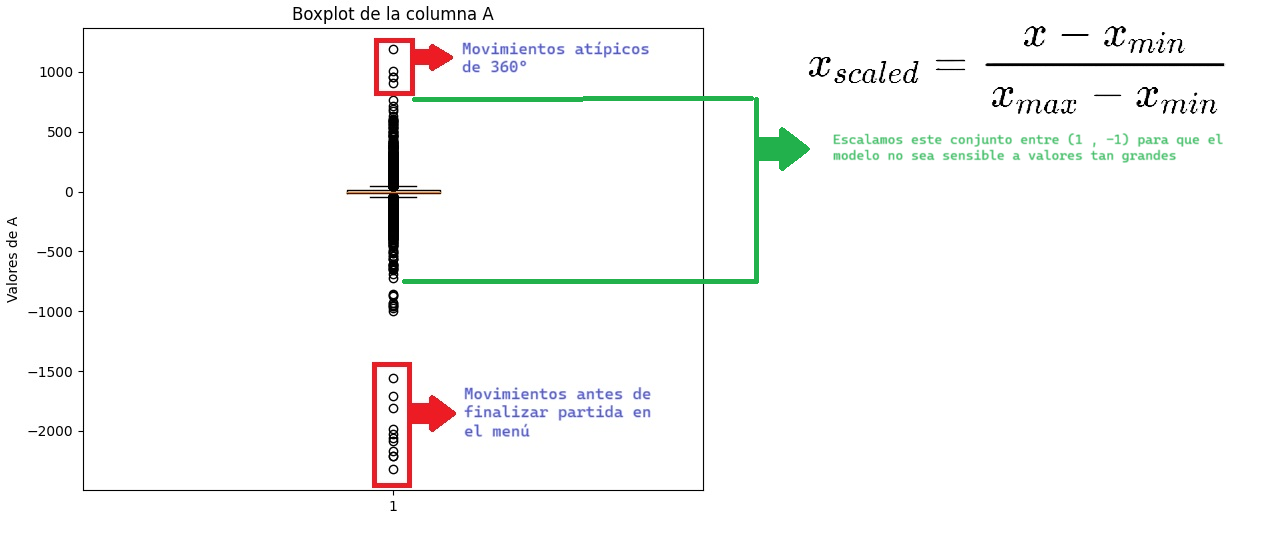

## Visualizacion Imagenes Dataset

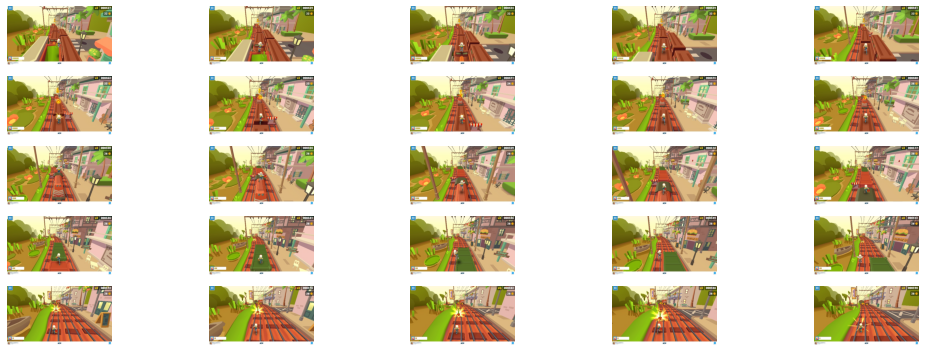

In [21]:
posicion_x = 10

fig, axes = plt.subplots(5, 5, figsize=(15, 5))

for i in range(5):
    for j in range(5):
        # Obtener la ruta de la imagen
        ruta_imagen = df_pov.iloc[(posicion_x+i), j]  # Elimina los corchetes

        # Abrir la imagen y convertirla a matriz numpy
        imagen = Image.open("../" + ruta_imagen)
        matriz_np = np.array(imagen)

        # Mostrar la imagen en el subplot correspondiente
        axes[i, j].imshow(matriz_np)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

Tamaño imagen -> (512, 165)
Tamaño matriz -> (165, 512, 3)


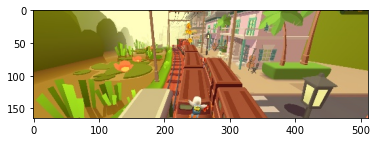

In [31]:
primera_fila = df_pov.iloc[10]
imagen = Image.open("../" +str(primera_fila.iloc[1]))
# Realiza el recorte (izquierda, arriba, derecha, abajo)
imagen = imagen.crop((0, 45, 512, 210))
matriz_np = np.array(imagen)
print("Tamaño imagen -> "+str(imagen.size))
print("Tamaño matriz -> "+ str(matriz_np.shape))
plt.imshow(matriz_np)
plt.axis('on')
plt.show()

# Funcion Del Batch

In [33]:
from keras.utils import Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro, **kwargs):
        self.df = df
        self.image_sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.filtro_SHARPEN = filtro
        super().__init__(**kwargs)  # Llamada al constructor de la clase base

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = imagen.crop((0, 45, 512, 210))     # Recortar imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        # Obtener y_batch después del one-hot encoding
        #y_batch = batch_df[['izquieda', 'derecha','delante']].values
        #y_batch = np.array(batch_df['mouse_final'].tolist())

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = imagen.crop((0, 45, 512, 210))     # Recortar imagen
                imagen = Image.fromarray(np.array(imagen))

                if self.filtro_SHARPEN == True :
                    imagen = imagen.filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

def comprobar_contenido(X_train , Y_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    print(Y_train[num_video])
    return Y_train[num_video]

In [34]:
class CombinedDataGenerator(Sequence):
    def __init__(self, generator_mapa, generator_pov):
        self.generator_mapa = generator_mapa
        self.generator_pov = generator_pov

    def __len__(self):
        return min(len(self.generator_mapa), len(self.generator_pov))

    def __getitem__(self, index):
        X_mapa, y_mapa = self.generator_mapa[index]
        X_pov, y_pov = self.generator_pov[index]

        # Asegurarse de que las etiquetas sean iguales
        assert np.array_equal(y_mapa, y_pov), "Las etiquetas no coinciden"

            # Pasamos los batch como lista de arrays de np
        return [X_mapa, X_pov], y_mapa  # o y_pov, ya que son iguales


    def __iter__(self):
        # Devolver un iterador que itera sobre los batches
        for i in range(len(self)):
            yield self[i]

    def on_epoch_end(self):
        self.generator_mapa.on_epoch_end()
        self.generator_pov.on_epoch_end()

# PREPARACIÒN ENTRENAMIENTO

## Train Split

In [35]:
# Modelo POV
X_train_Pov, X_test_Pov = train_test_split(df_pov, test_size=0.2, random_state=42)
X_train_Pov, X_valid_Pov = train_test_split(X_train_Pov, test_size=0.25, random_state=42)

print("Tamaño total: ",len(df_pov))
print("Tamaño del conjunto de entrenamiento:", len(X_train_Pov))
print("Tamaño del conjunto de prueba:", len(X_test_Pov))
print("Tamaño del conjunto de validación:", len(X_valid_Pov))

Tamaño total:  16985
Tamaño del conjunto de entrenamiento: 10191
Tamaño del conjunto de prueba: 3397
Tamaño del conjunto de validación: 3397


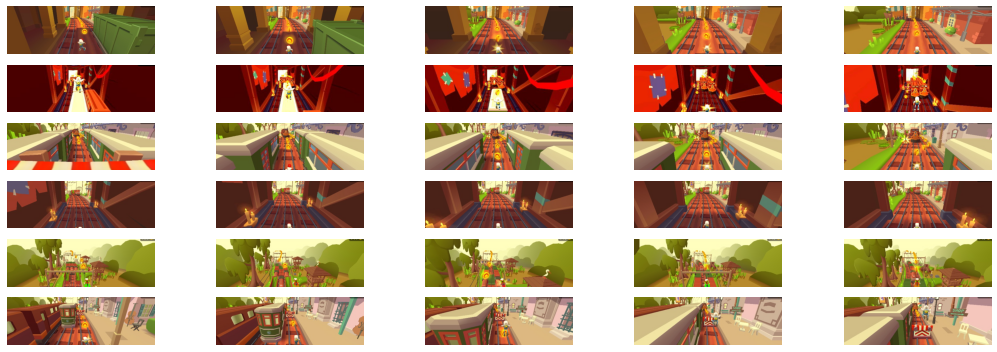

In [36]:
fig, axes = plt.subplots(6, 5, figsize=(15, 5))

for i in range(6):
    for j in range(5):
        # Obtener la ruta de la imagen
        ruta_imagen = X_test_Pov.iloc[i, j]  # Elimina los corchetes

        # Abrir la imagen y convertirla a matriz numpy
        imagen = Image.open("../" + ruta_imagen)
        imagen = imagen.crop((0, 45, 512, 210))     # Recortar imagen
        matriz_np = np.array(imagen)

        # Mostrar la imagen en el subplot correspondiente
        axes[i, j].imshow(matriz_np)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Generadores

In [37]:
BATCH = 3

In [38]:
altura_img_mini = 165
anchura_img_mini = 512
batch_size = BATCH #videos por batch

# Generadores de Batches Pov
train_generator_Pov = ImageDataGenerator(X_train_Pov, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True)
test_generator_Pov = ImageDataGenerator(X_test_Pov, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True)
valid_generator_Pov = ImageDataGenerator(X_valid_Pov, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True)

3397


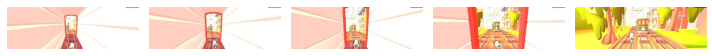

[0 1 0 0 0]
label_11


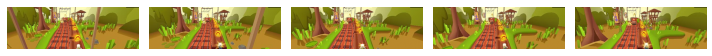

[1 0 0 0 0]
label_10


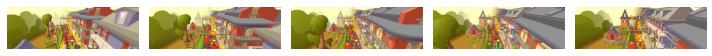

[0 0 1 0 0]
label_12


In [39]:
#Cantidad de batches en los que se divide el df
print(train_generator_Pov.__len__())

#Comprobamos funcionamiento bach
X_batch, y_batch = train_generator_Pov.__getitem__(4)

for i in range(0,batch_size):  # 2 es el maximo de conjunto de imagenes del batch creado
    # Seleccionamos ver la posicion numero 0 del batch creado
    label = comprobar_contenido(X_batch , y_batch,i)
    print(ETIQUETAS[np.argmax(label)])  #Obtener la columna de la etiqueta original

# Modelo - Entreno

In [40]:
from tensorflow.keras.models import Model 
#from keras.layers import Input, ConvLSTM2D, TimeDistributed, BatchNormalization,MaxPooling2D, Dropout, Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [41]:
from keras.layers import Input, TimeDistributed ,Conv2D, LSTM, BatchNormalization,MaxPooling2D, Dropout, Flatten, Dense ,Concatenate


def creacion_modelo_subway( input_shape_pov):

    input_shape_pov = Input(shape=input_shape_pov)

    # Capas Conv2D
    conv2d = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_shape_pov)
    batchnorm_layer = TimeDistributed(BatchNormalization())(conv2d)
    maxpool_layer = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(batchnorm_layer)
    dropout_mapa_01 = TimeDistributed(Dropout(0.2))(maxpool_layer)

    conv2d02 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(dropout_mapa_01)
    batchnorm_layer_02 = TimeDistributed(BatchNormalization())(conv2d02)
    maxpool_layer_02 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(batchnorm_layer_02)
    dropout_mapa_02 = TimeDistributed(Dropout(0.2))(maxpool_layer_02)

    conv2d03 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(dropout_mapa_02)
    batchnorm_layer_03 = TimeDistributed(BatchNormalization())(conv2d03)
    maxpool_layer_03 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(batchnorm_layer_03)
    dropout_mapa_03 = TimeDistributed(Dropout(0.3))(maxpool_layer_03)

    conv2d04 = TimeDistributed(Conv2D(245, (3, 3), activation='relu', padding='same'))(dropout_mapa_03)
    batchnorm_layer_04 = TimeDistributed(BatchNormalization())(conv2d04)
    maxpool_layer_04 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(batchnorm_layer_04)
    dropout_mapa_04 = TimeDistributed(Dropout(0.4))(maxpool_layer_04)


    flat1 = TimeDistributed(Flatten())(dropout_mapa_04)


    # Capa LSTM
    lstm01 = LSTM(128 , return_sequences=True)(flat1)
    lstm02 = LSTM(64)(lstm01)  # Puedes ajustar el número de unidades

    # Capas Densa (puedes ajustar el número de unidades y dropout) 400
    dense_out_02 = Dense(1024, activation='relu')(lstm02)
    drop_dense_02 = Dropout((0.3))(dense_out_02)

    # Capas Densa (puedes ajustar el número de unidades y dropout) 200
    dense_out_03 = Dense(512, activation='relu')(drop_dense_02)
    drop_dense_03 = Dropout((0.3))(dense_out_03)

    # Capa Salida
    output = Dense(len(ETIQUETAS), activation='softmax')(drop_dense_03)

    model = Model(inputs=input_shape_pov, outputs=output)

    return model

In [42]:
timesteps = 5
height = 165
width = 512
channels = 3

input_shape_pov = (timesteps, height, width, channels) # Modelo Pov

model = creacion_modelo_subway(input_shape_pov)

2024-08-16 20:02:37.079939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-16 20:02:40.017415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-16 20:02:40.017622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Callbacks

In [43]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

#Callbacks
early_stopping = EarlyStopping(monitor= 'val_categorical_accuracy', patience=20, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('modelo_merge_checkpoint.h5',monitor='val_categorical_accuracy',save_best_only=True,verbose=1)
'''
reduce_lr = ReduceLROnPlateau(  monitor='val_categorical_accuracy',
                                factor=0.2,
                                patience=5,
                                min_lr=0.00001,
                                verbose=1)
'''

"\nreduce_lr = ReduceLROnPlateau(  monitor='val_categorical_accuracy',\n                                factor=0.2,\n                                patience=5,\n                                min_lr=0.00001,\n                                verbose=1)\n"

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 165, 512, 3)   0         
                             ]                                   
                                                                 
 time_distributed (TimeDist  (None, 5, 165, 512, 32)   896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 165, 512, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 82, 256, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 82, 256, 32)    0     

In [45]:
import time

# Registro del tiempo de inicio
start_time = time.time()

# Entrenamiento Mini-Mapa
history = model.fit(train_generator_Pov, epochs=1000, validation_data=valid_generator_Pov, callbacks=[early_stopping,model_checkpoint])

model.save('modelo_merge_subway.h5')

# Registro del tiempo de finalización
end_time = time.time()

Epoch 1/1000


2024-08-16 20:03:21.013191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-16 20:03:23.997015: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x70392f632aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-16 20:03:23.997034: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-08-16 20:03:24.472514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 20:03:26.699652: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3397/3397 [==============================] - ETA: 0s - loss: 1.5042 - categorical_accuracy: 0.3526
Epoch 1: val_categorical_accuracy improved from -inf to 0.34236, saving model to modelo_merge_checkpoint.h5


/usr/lib/python3/dist-packages/keras/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3397/3397 [==============================] - 465s 134ms/step - loss: 1.5042 - categorical_accuracy: 0.3526 - val_loss: 1.4816 - val_categorical_accuracy: 0.3424
Epoch 2/1000
3397/3397 [==============================] - ETA: 0s - loss: 1.4884 - categorical_accuracy: 0.3534
Epoch 2: val_categorical_accuracy improved from 0.34236 to 0.37651, saving model to modelo_merge_checkpoint.h5
3397/3397 [==============================] - 419s 123ms/step - loss: 1.4884 - categorical_accuracy: 0.3534 - val_loss: 1.4491 - val_categorical_accuracy: 0.3765
Epoch 3/1000
3397/3397 [==============================] - ETA: 0s - loss: 1.4783 - categorical_accuracy: 0.3624
Epoch 3: val_categorical_accuracy did not improve from 0.37651
3397/3397 [==============================] - 415s 122ms/step - loss: 1.4783 - categorical_accuracy: 0.3624 - val_loss: 1.4709 - val_categorical_accuracy: 0.3421
Epoch 4/1000
3397/3397 [==============================] - ETA: 0s - loss: 1.4715 - categorical_accuracy: 0.3597
Epoch 4

In [46]:
# Calcula la diferencia de tiempo en segundos
training_time_seconds = end_time - start_time

# Convierte el tiempo de entrenamiento a horas
training_time_hours = training_time_seconds / 3600  # 3600 segundos en una hora

# Imprime el tiempo de entrenamiento en horas
print(f"El entrenamiento duró aproximadamente {training_time_hours:.2f} horas.")

El entrenamiento duró aproximadamente 8.53 horas.


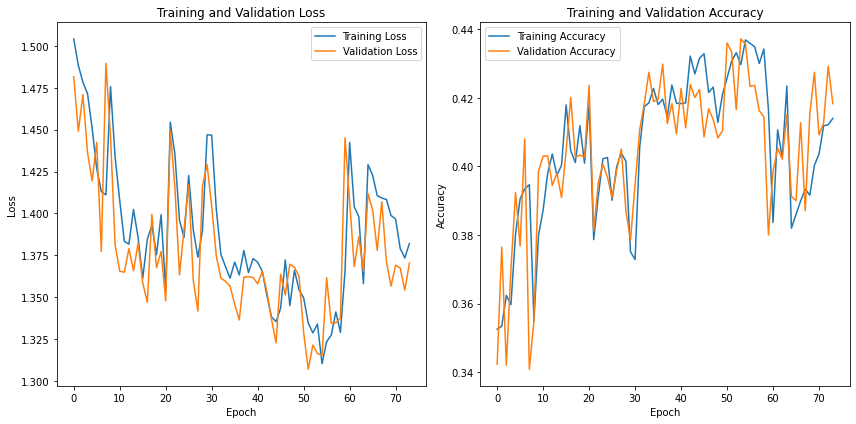

In [47]:
# Extrae la información de la historia
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

# Crea subgráficos para la pérdida y la precisión
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Ajusta el diseño de los subgráficos
plt.tight_layout()

# Muestra los gráficos
plt.show()

## Ver como se comporta el modelo

In [48]:
from sklearn.metrics import f1_score,confusion_matrix

valores_originales = X_test_Pov[ETIQUETAS].copy()
valores_originales.reset_index(drop=True, inplace=True)

In [49]:
valores_originales

label_10  label_11  label_12  label_13  label_14
0            0         1         0         0         0
1            0         1         0         0         0
2            0         0         1         0         0
3            0         0         1         0         0
4            1         0         0         0         0
...        ...       ...       ...       ...       ...
3392         0         1         0         0         0
3393         0         0         1         0         0
3394         1         0         0         0         0
3395         0         0         1         0         0
3396         1         0         0         0         0

[3397 rows x 5 columns]

In [53]:
# Generar predicciones en el conjunto de prueba
predictions = model.predict(test_generator_Pov)

1133/1133 [==============================] - 72s 63ms/step


In [54]:
predictions

array([[0.2838773 , 0.09462123, 0.43188676, 0.10766909, 0.08194559],
       [0.2763318 , 0.26083735, 0.28954682, 0.0654894 , 0.10779456],
       [0.11935718, 0.1399457 , 0.4481463 , 0.08120528, 0.21134552],
       ...,
       [0.24136698, 0.05876272, 0.10300818, 0.4203311 , 0.17653102],
       [0.31911662, 0.10083049, 0.38385758, 0.05497921, 0.1412161 ],
       [0.34058556, 0.2975021 , 0.00592341, 0.22654511, 0.12944382]],
      dtype=float32)

In [55]:
# Convertir las probabilidades a etiquetas de clase
predicted_classes = np.argmax(predictions, axis=1)

#Convertimos las etiquetas one  hot a numeros
true_classes = np.argmax(valores_originales.values, axis=1)

In [56]:
predicted_classes

array([2, 2, 2, ..., 3, 2, 0])

In [57]:
true_classes

array([1, 1, 2, ..., 0, 2, 0])

In [58]:
# Calcular el F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print('F1 Score:', f1)

F1 Score: 0.37136894629495376


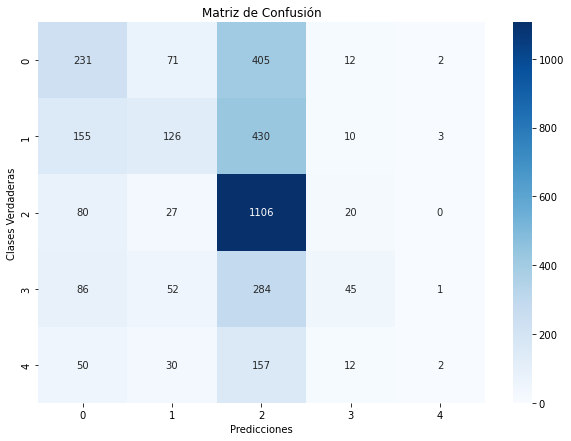

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Añadir etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')

# Mostrar el gráfico
plt.show()

## Resultatado Entrenamientos

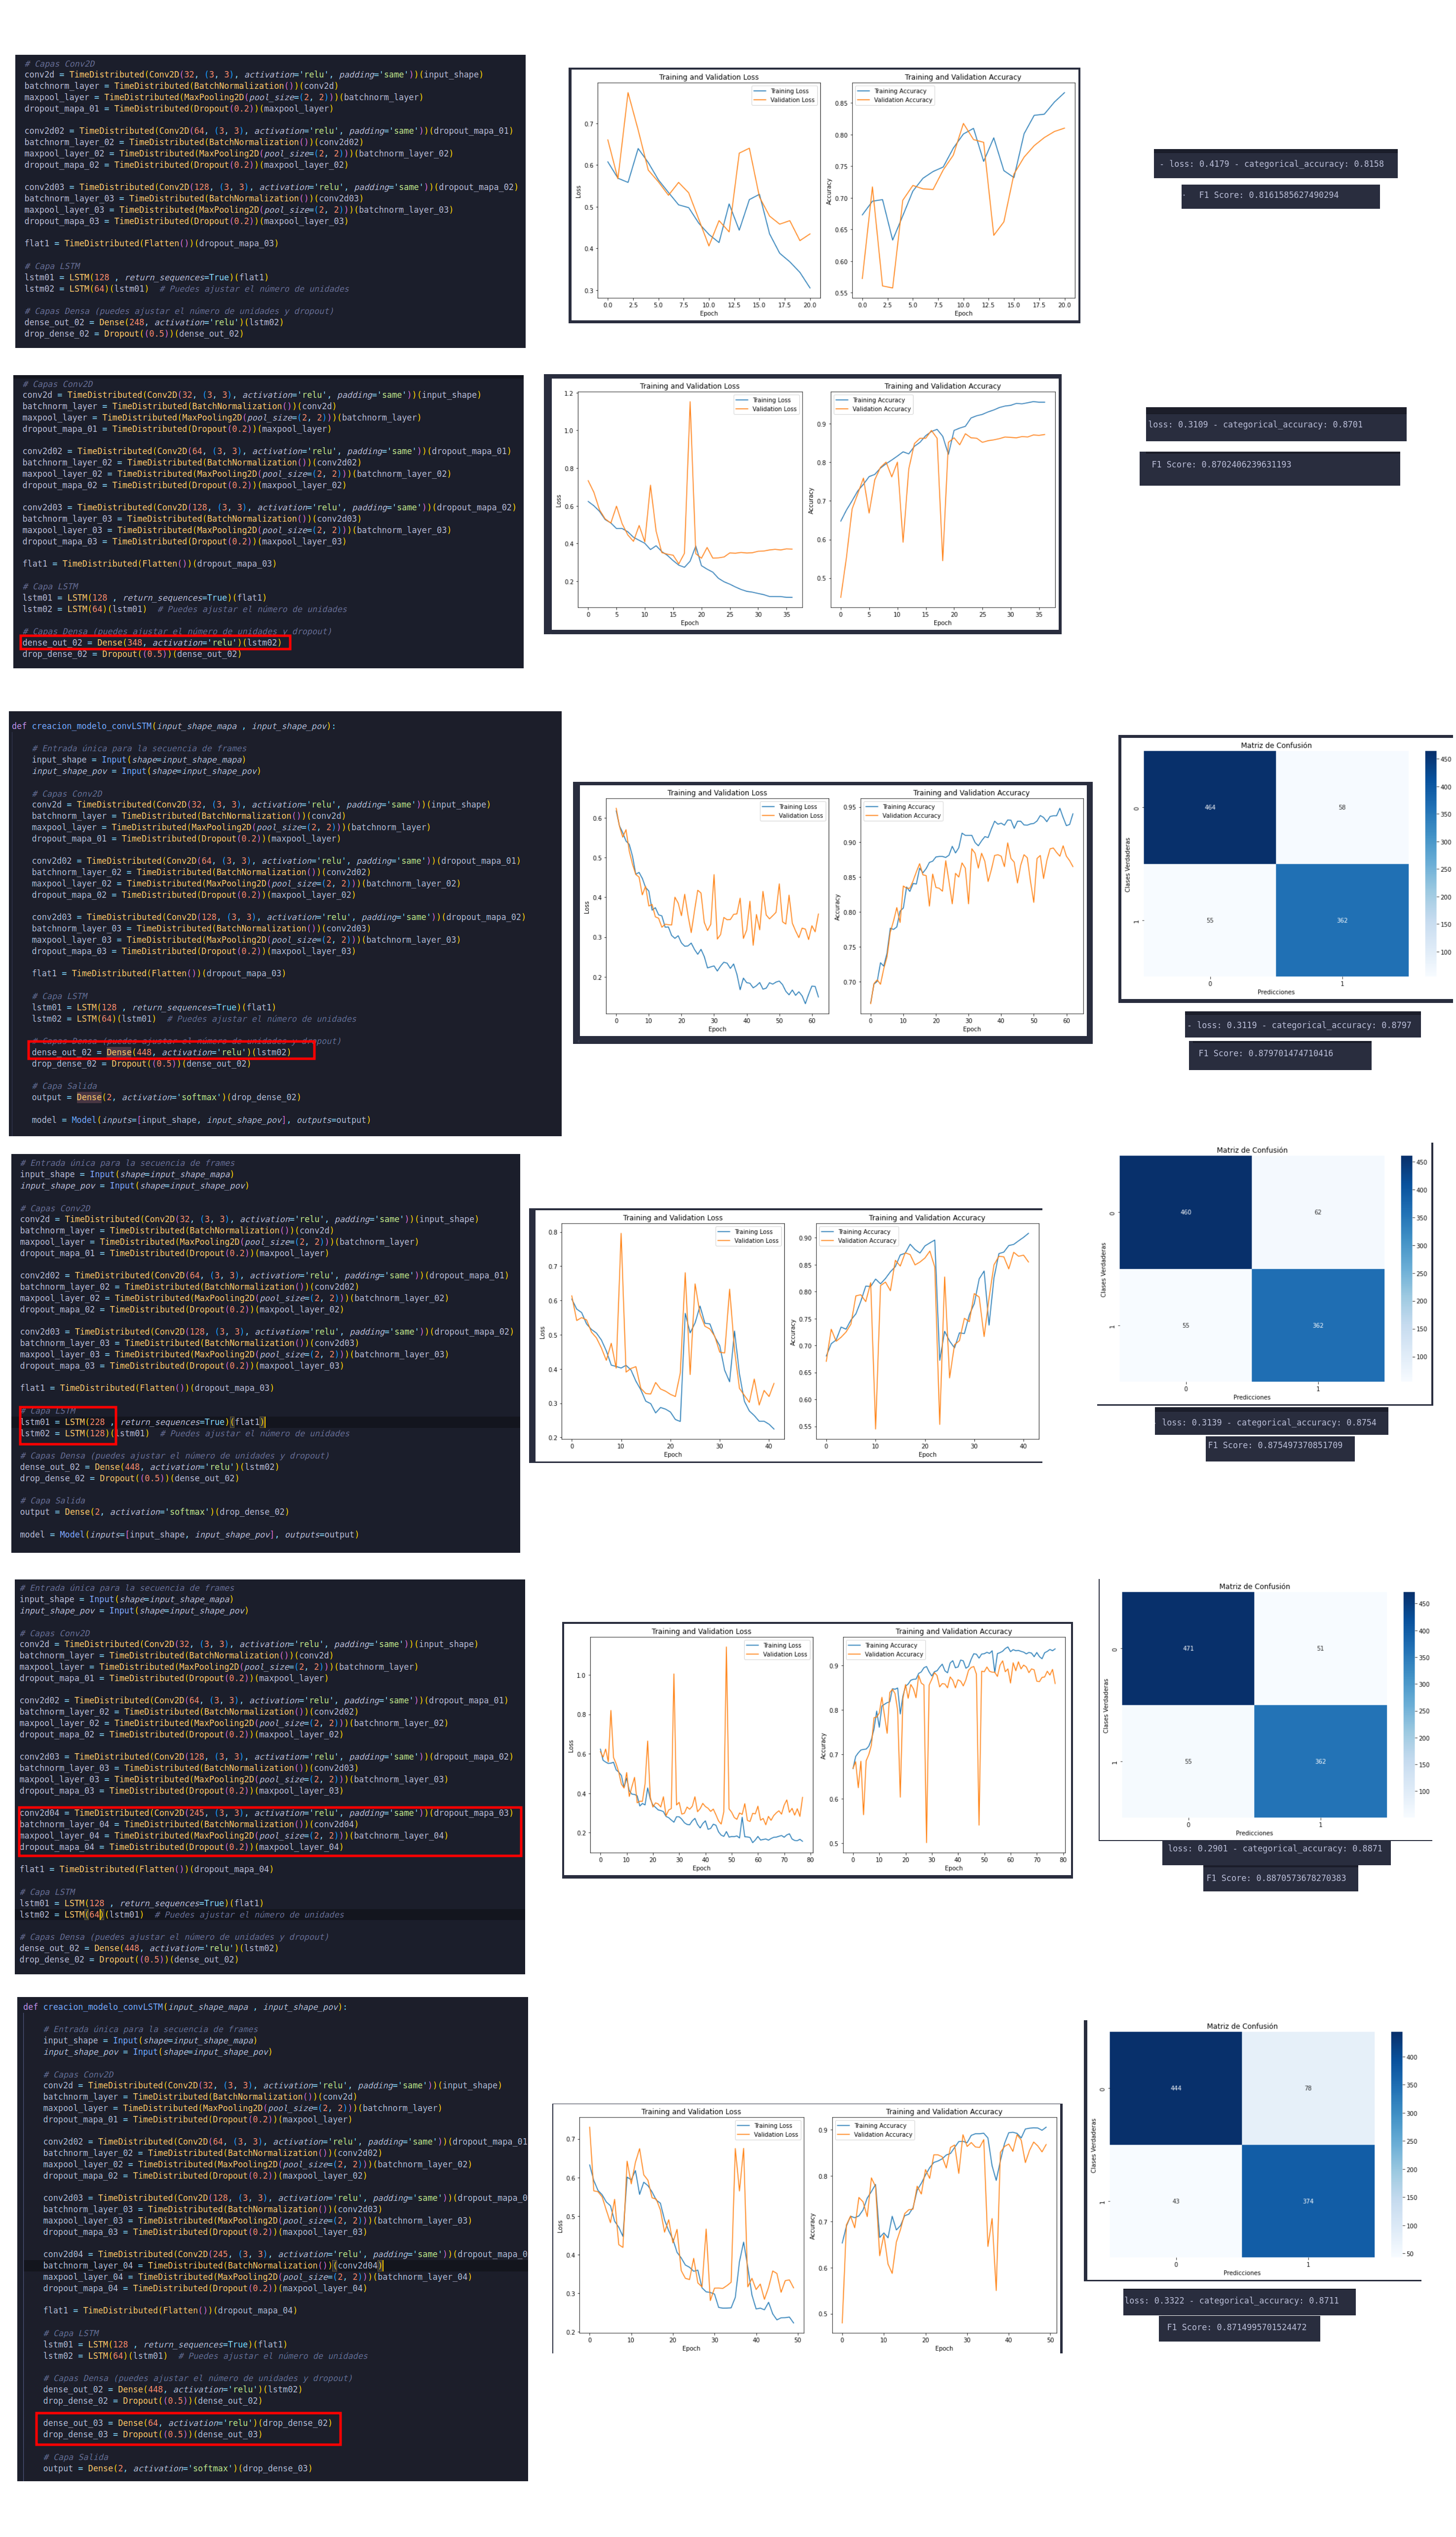